In [2]:
from quadmodel.inference.forward_model import forward_model
import os
import numpy as np

### Forward modeling image flux ratios with quadmodel

In the following cell, we define the parameters we want to sample in the forward model, and set the lens data class

In [5]:
# the path where we generate output samples
output_path = os.getcwd() + '/example_inference_output/'
# a unique integer that is appended to the filenames
job_index = 1
# the number of realizations to accept in the posterior; the function will run until this many samples are generated
n_keep = 2
# sets the tolerance for the summary statistics (a reasonable value is 0.05, using a larger value here for speed)
summary_statistic_tolerance = 0.5
# defines the lens data class (can also be a class, see quadmodel.data.quad_base)
lens_data = 'B1422'
# defines the priors for parameters sampled in the forward model
realization_priors = {}
realization_priors['PRESET_MODEL'] = 'CDM'
realization_priors['sigma_sub'] = ['UNIFORM', 0.0, 0.1]
realization_priors['LOS_normalization'] = ['UNIFORM', 0.25, 0.5]
realization_priors['power_law_index'] = ['FIXED', -1.9]
realization_priors['log_m_host'] = ['GAUSSIAN', 13.3, 0.3]
realization_priors['log10c0'] = ['UNIFORM', 2, 4]
realization_priors['beta'] = ['FIXED', 0.8]
realization_priors['zeta'] = ['FIXED', -0.25]

### Run the simulation

In [6]:
forward_model(output_path, job_index, lens_data, n_keep, realization_priors, tolerance=summary_statistic_tolerance,
                  verbose=True)

reading output to files: 
/Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/parameters.txt
/Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/fluxes.txt
starting with 0 samples accepted, 2 remain
existing magnifications:  None
samples remaining:  2
realization contains 2076 halos.
realization parameter array:  [ 0.08951167  0.36144516 13.15594608  3.44034342]
optimization 1
aperture size:  100
minimum mass in aperture:  7.0
minimum global mass:  7.0
N foreground halos:  1
N subhalos:  179
10
20
30
40
50
60
70
80
90
100
110
PSO done... 
source plane chi^2:  68455.05430514686
total chi^2:  68455.05430514686
starting amoeba... 
optimization done.
Recovered source position:  (array([-0.41353966, -0.41353975, -0.41353961, -0.41353944]), array([0.29125895, 0.29125897, 0.29125909, 0.29125912]))
optimization 2
aperture size:  0.2
minimum mass in aperture:  0.0
minimum global mass:  7.0
N foreground halos:  4
N subhalos:  236
starting amoeba...

### Examine the output

The simulation output includes files named fluxes.txt, parameters.txt, and simulation_output_1, simulation_output_2, etc.

In [11]:
f = open(output_path + 'job_'+str(job_index)+'/parameters.txt', 'r')
param_names = f.readlines()[0]
print('PARAMETER NAMES:')
print(param_names)
f.close()

accepeted_parameters = np.loadtxt(output_path + 'job_'+str(job_index)+'/parameters.txt', skiprows=1)
print('ACCEPTED PARAMETERS:')
print(accepeted_parameters)
# the first set of parameters are the ones specified in kwargs_realization (see cell #2), the rest are the source size, 
# macromodel parameters, and the last parameter is the summary statistic

accepeted_mags = np.loadtxt(output_path + 'job_'+str(job_index)+'/fluxes.txt')
print('\nACCEPTED MAGNIFICATIONS:')
print(accepeted_mags)

PARAMETER NAMES:
sigma_sub LOS_normalization log_m_host log10c0 source_size_pc gamma gamma_ext a4 

ACCEPTED PARAMETERS:
[[ 8.9512000e-02  3.6144500e-01  1.3155946e+01  3.4403430e+00
   4.9979797e+01  2.0760840e+00  3.2559500e-01 -1.1214000e-02
   2.1952000e-01]
 [ 9.1132000e-02  3.7532000e-01  1.3529395e+01  3.2645070e+00
   3.3691294e+01  2.1409580e+00  2.1204300e-01  6.1790000e-03
   2.9007700e-01]]

ACCEPTED MAGNIFICATIONS:
[[1.       0.84308  0.310325 0.047081]
 [0.694737 1.       0.576582 0.025849]]


### Visualize accepeted realizations

The pickeled classes in simulation_output allow you to visualize the accepeted realizations

In [12]:
import pickle
f = open(output_path + 'job_'+str(job_index)+'/simulation_output_1', 'rb')
simulation_output = pickle.load(f)
x_image, y_image = simulation_output.data.x, simulation_output.data.y
lens_system = simulation_output.lens_system

npix = 150
rminmax = 1.25
_r = np.linspace(-rminmax, rminmax, npix)
xx, yy = np.meshgrid(_r, _r)
shape0 = xx.shape
lensmodel, kwargs_lens = lens_system.get_lensmodel()
lensmodel_macro, kwargs_macro = lens_system.get_lensmodel(include_substructure=False)

kappa = lensmodel.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)
kappa_macro = lensmodel_macro.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)

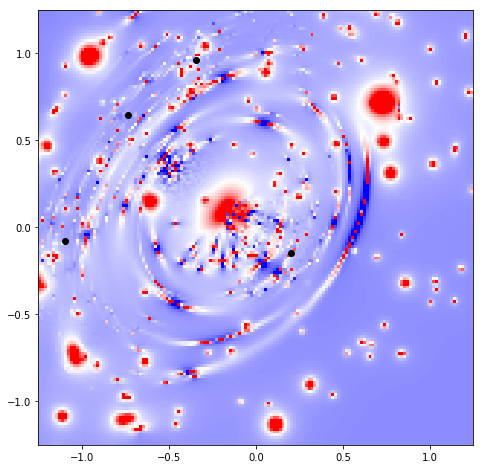

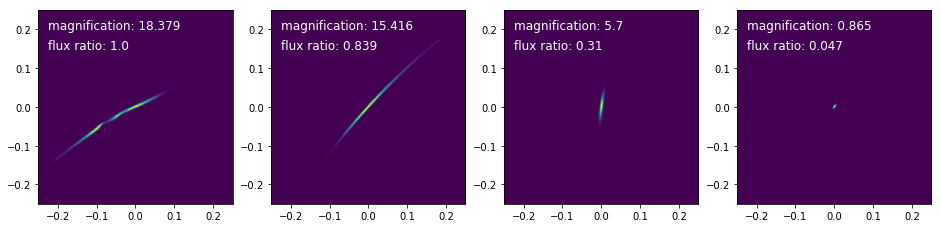

In [14]:
import matplotlib.pyplot as plt

vminmax = 0.1
kappa_subs_nonlinear = kappa - kappa_macro
extent = [-rminmax, rminmax, -rminmax, rminmax]

fig = plt.figure(1)
fig.set_size_inches(8, 8)
plt.imshow(kappa_subs_nonlinear, vmin=-vminmax, vmax=vminmax, origin='lower', cmap='bwr', 
           extent=extent)
plt.scatter(x_image, y_image, color='k')
plt.show()

source_size_pc = accepeted_parameters[0, 4]
lens_system.plot_images(x_image, y_image, source_size_pc, lensmodel, kwargs_lens)

Using the plot_images routine in lens_system, you can also ray trace through the lens system to see what the images look like (or how they would look with an ridiculously large telescope and no PSF) 